## Описание проекта
Нужно защитить данные клиентов страховой компании. Необходимо разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию.  
Защитить данные надо так, чтобы при преобразовании качество моделей машинного обучения не ухудшилось.

## 1. Загрузка данных

Загрузим необходимые библиотеки и функции.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

Прочтем данные

In [2]:
insurance = pd.read_csv('/datasets/insurance.csv')
insurance.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Проведем исследовательский анализ данных.  
Переименуем столбцы (для удобства) и посмотрим на разброс параметров.

In [3]:
insurance.columns = ['пол', 'возраст', 'зарплата', 'члены_семьи', 'страховые_выплаты']

print('Возраст от', int(insurance['возраст'].min()), 'до', int(insurance['возраст'].max()), 'лет.')
print('Зарплата от', int(insurance['зарплата'].min()), 'до', int(insurance['зарплата'].max()), 'руб.')
print('Членов семьи от', insurance['члены_семьи'].min(), 'до', insurance['члены_семьи'].max(), 'человек.')
print('Страховые выплаты от', insurance['страховые_выплаты'].min(), 'до', insurance['страховые_выплаты'].max(), 'раз.')

Возраст от 18 до 65 лет.
Зарплата от 5300 до 79000 руб.
Членов семьи от 0 до 6 человек.
Страховые выплаты от 0 до 5 раз.


Параметры укладываются в разумные пределы. Конечно, зарплата в 5300р. маловата, но в принципе возможна. Ноль членов семьи - видимо, имеются в виду одинокие и бездетные.  
Теперь проверим на пропуски.

In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
пол                  5000 non-null int64
возраст              5000 non-null float64
зарплата             5000 non-null float64
члены_семьи          5000 non-null int64
страховые_выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Пропусков нет. Дубликаты.

In [5]:
insurance.duplicated().sum()

153

153 дубликата. Люди одного пола и возраста, с одинаковой зарплатой, составом семьи и одинаково получающие страховые выплаты в относительно небольшой выборке из 5000 человек? Возможно, но очень маловероятно. Удаляем дубликаты.

In [6]:
insurance.drop_duplicates(inplace=True)

Посмотрим на корреляцию признаков между собой и с целевым признаком.

In [7]:
insurance.corr()

,пол,возраст,зарплата,члены_семьи,страховые_выплаты
пол,1.000000,0.001953,0.015456,-0.007315,0.011565
возраст,0.001953,1.000000,-0.017386,-0.009064,0.654964
зарплата,0.015456,-0.017386,1.000000,-0.031687,-0.013123
члены_семьи,-0.007315,-0.009064,-0.031687,1.000000,-0.039303
страховые_выплаты,0.011565,0.654964,-0.013123,-0.039303,1.000000


In [8]:
insurance.groupby('возраст')['страховые_выплаты'].mean()

возраст
18.0    0.000000
19.0    0.000000
20.0    0.000000
21.0    0.000000
22.0    0.000000
23.0    0.000000
24.0    0.000000
25.0    0.000000
26.0    0.000000
27.0    0.000000
28.0    0.000000
29.0    0.000000
30.0    0.000000
31.0    0.000000
32.0    0.000000
33.0    0.000000
34.0    0.000000
35.0    0.000000
36.0    0.000000
37.0    0.000000
38.0    0.000000
39.0    0.000000
40.0    0.000000
41.0    0.000000
42.0    0.602151
43.0    1.000000
44.0    1.000000
45.0    1.000000
46.0    1.000000
47.0    1.000000
48.0    1.000000
49.0    1.729730
50.0    2.000000
51.0    2.000000
52.0    2.000000
53.0    2.000000
54.0    2.000000
55.0    3.000000
56.0    3.000000
57.0    3.000000
58.0    3.000000
59.0    4.000000
60.0    4.000000
61.0    4.000000
62.0    4.000000
65.0    5.000000
Name: страховые_выплаты, dtype: float64

Прослеживается корреляция между целевым признаком и возрастом.Выплаты начинаются с 42 лет и в среднем увеличиваются с возрастом.  Видимо, это медицинская страховка. Остальные признаки друг от друга приктически независимы.  
Посмотрим на распределение по возрасту.

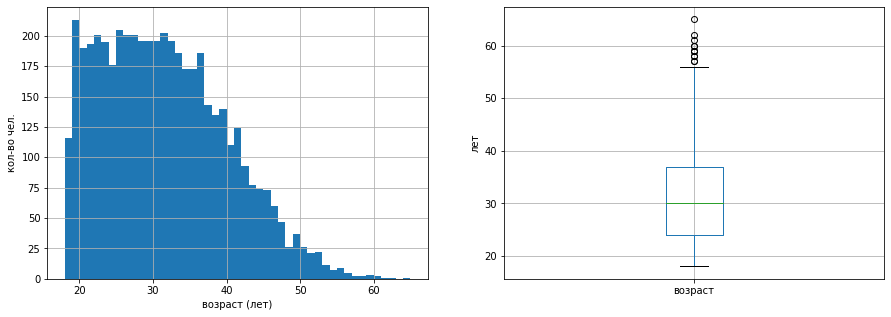

In [9]:
plt.rcParams['figure.figsize'] = [15, 5]
ax = plt.subplot(121)
ax.set_xlabel('возраст (лет)')
ax.set_ylabel('кол-во чел.')
insurance['возраст'].hist(bins=int(insurance['возраст'].max()-insurance['возраст'].min()));

ax = plt.subplot(122)
ax.set_ylabel('лет')
pd.DataFrame(insurance['возраст']).boxplot();

Похоже на распределение Пуассона. Возраст старше 55 лет можно отнести к выбросам.  
Что с зарплатой?

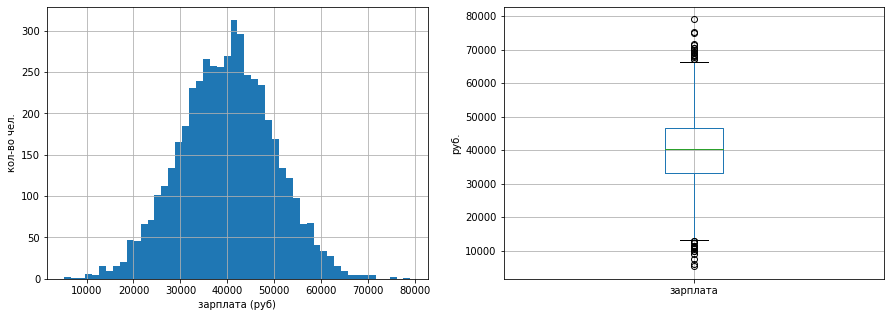

In [10]:
ax = plt.subplot(121)
ax.set_xlabel('зарплата (руб)')
ax.set_ylabel('кол-во чел.')
insurance['зарплата'].hist(bins=50);

ax = plt.subplot(122)
ax.set_ylabel('руб.')
pd.DataFrame(insurance['зарплата']).boxplot();

Практически нормальное распределение. Выбросы - зарплата меньше 15000 и больше 65000.  
Теперь размер семьи.

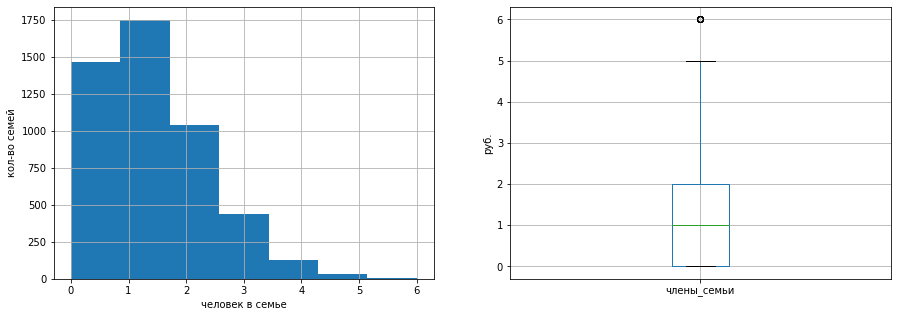

In [11]:
ax = plt.subplot(121)
ax.set_xlabel('человек в семье')
ax.set_ylabel('кол-во семей')
insurance['члены_семьи'].hist(bins=7);

ax = plt.subplot(122)
ax.set_ylabel('руб.')
pd.DataFrame(insurance['члены_семьи']).boxplot();

Удаляем выбросы.

In [12]:
insurance = insurance.query('возраст<55  and 15000<зарплата<65000 and члены_семьи<=5')
insurance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4754 entries, 0 to 4999
Data columns (total 5 columns):
пол                  4754 non-null int64
возраст              4754 non-null float64
зарплата             4754 non-null float64
члены_семьи          4754 non-null int64
страховые_выплаты    4754 non-null int64
dtypes: float64(2), int64(3)
memory usage: 222.8 KB


In [13]:
insurance['пол'].value_counts()

0    2389
1    2365
Name: пол, dtype: int64

Мужчин и женщин примерно поровну.  
Выделим целевой признак и посмотрим на его распредление. Разделим выборку на тренировочную и тестовую.

In [14]:
features = insurance.drop('страховые_выплаты', axis=1)
target = insurance['страховые_выплаты']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

target.value_counts()

0    4225
1     416
2     113
Name: страховые_выплаты, dtype: int64

## 2. Умножение матриц

**Вопрос:** Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)

**Ответ:** При умножении признаков на обратимую матрицу качество линейной регрессии изменится. По сути дела модель не сможет предсказывать.

**Обоснование:** При умножении обратимой матрицы $A(nхn)$ на вектор признака $b(n)$ каждое полученное значение $c(i)$ нового вектора признака зависит от всех значений признака для всех событий: 
  
$$
c(i)=a(i,1)*b(1)+a(i,2)*b(2)...a(i,n)*b(n)
$$  
То есть в нашем случае в зашифрованных данных на каждого клиента перемешаны данные всех остальных клиентов. Конечно, при таких обстоятельствах задача машинного обучения нерешаема.

## 3. Алгоритм преобразования

Вместо умножения случайно полученной обратимой матрицы на признаки умножим её на события. При этом в каждое событие останется уникальным, т.к при преобразовании будут использованы только значения, присущие этому событию (в данном случае - клиенту банка). Матрица - ключ шифрования - должна быть обратимой для возможности обратного преобразования, т.е для восстановления исходных данных из зашифрованных.  
Итак, алгоритм действий:  
  
1. Генерируем случайную квадратную матрицу-ключ размерностью в кол-во признаков. Проверяем на обратимость.
2. Транспонируем исходную матрицу признаков.  
3. Умножаем полученные столбцы (бывшие строки) на матрицу-ключ.  
4. Транспонируем полученную матрицу обратно, присваиваем столбцам старые названия.  
  
Должна получиться матрица прежней размерности, но с непонятными значениями. По идее, обучив модель на преобразованных таким образом данных, мы должны получить результат, схожий с результатом, полученным при обучении на оригинальных данных, т.к. уникальность признаков для каждого события (клиента) сохраняется.


## 4. Проверка алгоритма

Проверим нашу теорию.  
Cгенерируем случайную квадратную матрицу  𝑃  размерностью в кол-во признаков (столбцов) и проверим её на обратимость, умножив на обратную. Должна получиться единичная матрица.

In [15]:
P = np.random.normal(size=(features.shape[1],features.shape[1]))
P.dot(np.linalg.inv(P))

array([[ 1.00000000e+00, -8.36861785e-17,  8.35264509e-17,
        -5.83452903e-17],
       [-1.12912000e-16,  1.00000000e+00, -2.67369175e-16,
        -1.42762012e-17],
       [ 1.54362129e-16,  9.18919475e-17,  1.00000000e+00,
         3.95103934e-17],
       [ 1.59978772e-16, -2.20455995e-17, -2.49269355e-17,
         1.00000000e+00]])

Готово.  
Теперь напишем функцию, которая принимает на вход исходный датасет с признаками и матрицу-ключ, <u>ТРАНСПОНИРУЕТ ДАТАСЕТ</u>, умножает полученные столбцы (<u>БЫВШИЕ СТРОКИ</u>) на ключ, ТРАНСПОНИРУЕТ МАТРИЦУ ОБРАТНО и присваивает новым столбцам старые названия.

In [16]:
def cipher(features,key):
    
    features_T = features.T
    
    new_features = pd.DataFrame()
    for column in features_T.columns:
        new_features[column] = features_T[column].dot(key)
        
    new_features = new_features.T
    new_features.columns = features.columns
    
    return new_features

In [17]:
features.loc[1, :]

пол                0.0
возраст           46.0
зарплата       38000.0
члены_семьи        1.0
Name: 1, dtype: float64

Проверим качество модели линейной регрессии.

In [18]:
model = LinearRegression()
model.fit(features_train, target_train)
pred_train = model.predict(features_train)
pred_test = model.predict(features_test)
print('До шифрования:')
print("Трениров. R2 =", r2_score(target_train, pred_train))
print("Тестовая  R2 =", r2_score(target_test, pred_test))


До шифрования:
Трениров. R2 = 0.416381137245184
Тестовая  R2 = 0.40468227398383005


Преобразуем наши признаки.

In [19]:
transform_features_train = cipher(features_train, P)
transform_features_test = cipher(features_test, P)
transform_features_train.head()

,пол,возраст,зарплата,члены_семьи
749,-10336.801196,-8427.484590,-19191.137959,-85854.753309
331,-9358.087408,-7640.745391,-17387.615509,-77844.045206
2550,-6362.948116,-5204.571033,-11835.287186,-53042.943292
4422,-5539.351582,-4528.511933,-10304.104962,-46176.994145
1358,-9846.179313,-8033.202474,-18287.820794,-81848.983126


Как видим, признаки вполне себе зашифрованы. Теперь проверим качество модели на преобразованных данных.

In [20]:
model.fit(transform_features_train, target_train)
pred_train = model.predict(transform_features_train)
pred_test = model.predict(transform_features_test)
print('После шифрования:')
print("Трениров. R2 =", r2_score(target_train, pred_train))
print("Тестовая  R2 =", r2_score(target_test, pred_test))

После шифрования:
Трениров. R2 = 0.41638113724518233
Тестовая  R2 = 0.404682273983869


Значения метрик до и после шифрования совпадают до 14 знака после запятой, задача решена.  
Настало время обратного преобразования - восстановления исходных данных с помощью ключа. Для восстановления проделаем все те же операции, но уже между измененными данными и матрицей, обратной ключу.

In [21]:
features.head(10)

,пол,возраст,зарплата,члены_семьи
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0
5,1,43.0,41000.0,2
6,1,39.0,39700.0,2
7,1,25.0,38600.0,4
8,1,36.0,49700.0,1
9,1,32.0,51700.0,1


In [22]:
crypt = cipher(features,P)
crypt.head(10)

,пол,возраст,зарплата,члены_семьи
0,-11374.649704,-9287.755974,-21135.831280,-94633.684087
1,-8699.795884,-7113.187151,-16180.874943,-72507.113219
2,-4804.433124,-3931.043596,-8939.068188,-40070.201029
3,-9575.418654,-7808.863152,-17780.963682,-79559.793621
4,-5979.534903,-4887.107457,-11116.358026,-49797.625385
5,-9393.314469,-7675.020133,-17463.530171,-78228.657176
6,-9098.049170,-7431.967728,-16911.996342,-75747.520337
7,-8858.047753,-7225.732556,-16454.203074,-73646.994272
8,-11402.543069,-9307.169500,-21182.679451,-94823.094933
9,-11866.708183,-9682.468288,-22039.653453,-98637.462588


In [23]:
round(cipher(crypt, np.linalg.inv(P))).head(10)

,пол,возраст,зарплата,члены_семьи
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0
5,1.0,43.0,41000.0,2.0
6,1.0,39.0,39700.0,2.0
7,1.0,25.0,38600.0,4.0
8,1.0,36.0,49700.0,1.0
9,1.0,32.0,51700.0,1.0


Данные восстановлены, алгоритм работает.

##### В функции chifer() матрица сначала транспонируется (строки становятся столбцами, а столбцы - строками). Поэтому мы умножаем матрицу-ключ на вектора, которые изначально были строками.

ПРОВЕРИМ УТВЕРЖДЕНИЕ, ЧТО УМНОЖЕНИЕ ПРИЗНАКОВ НА ОБРАТИМУЮ МАТРИЦУ УХУДШАЕТ КАЧЕСТВО МОДЕЛИ.  
Генерируем две новые матрицы P1 и P2, но размерностью в кол-во СТРОК train и target, пишем ту же функцию, но БЕЗ ТРАНСПОНИРОВАНИЯ.

In [24]:
P1 = np.random.normal(size=(features_train.shape[0],features_train.shape[0]))
P2 = np.random.normal(size=(features_test.shape[0],features_test.shape[0]))

def cipher_1(features,key):
    new_features = pd.DataFrame()
    for column in features.columns:
        new_features[column] = features[column].dot(key)
    return new_features

Преобразуем данные.

In [25]:
transform_features_train = cipher_1(features_train, P1)
transform_features_test = cipher_1(features_test, P2)
transform_features_train.head()

,пол,возраст,зарплата,члены_семьи
0,-3.655099,3501.724807,2.493868e+06,77.034056
1,3.583692,896.804743,9.158108e+03,3.162593
2,-4.801034,425.361718,-4.147689e+05,-21.350955
3,81.913345,2797.222381,3.577486e+06,18.971338
4,-49.716248,1541.063768,1.830206e+06,-2.019857


In [26]:
model.fit(transform_features_train, target_train)
pred_train = model.predict(transform_features_train)
pred_test = model.predict(transform_features_test)
print('После шифрования:')
print("Трениров. R2 =", r2_score(target_train, pred_train))
print("Тестовая  R2 =", r2_score(target_test, pred_test))

После шифрования:
Трениров. R2 = 0.002665364924450242
Тестовая  R2 = -0.0015861139608654984


Как видим, качество модели заметно ухудшилось, что согласуется с нашим утверждением из п.2